In [1]:
import qiskit

In [2]:
qiskit.__version__

'1.1.0'

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum",
                               token = "") #insert your ibm acces token for the quantum computer


In [4]:
#save the access token locally so that you do not need to retype it every time

QiskitRuntimeService.save_account(channel="ibm_quantum",
                               token = "") 

In [5]:
backend = service.backend(name = "ibm_brisbane")

In [6]:
backend.num_qubits

127

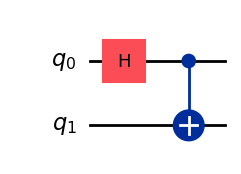

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0,1)

qc.draw(output='mpl')

In [2]:
from qiskit.quantum_info import Pauli

ZZ = Pauli("ZZ")
ZI = Pauli("ZI")
IZ = Pauli("IZ")
XX = Pauli("XX")
XI = Pauli("XI")
IX = Pauli("IX")

observables = [ZZ,ZI,IZ,XX,XI,IX]

In [4]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.        ,  0.078125  ,  0.078125  ,  1.        , -0.01367188,
       -0.01367188]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.0003745, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 0.001326792, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 8192, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'stabilizer', 'required_memory_mb': 0, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.993896484375, 'simulator_metadata': [{'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.0003745, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'd

In [7]:
def get_qc_for_n_qubit_GHZ_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i,i+1)
    return qc

n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)
#qc.draw(output='mpl')

In [8]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z'+'I'*i+'Z'+'I'*(n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(op_str) for op_str in operator_strings]


['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [9]:
#optimize the problem for quantum execution
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"
backend = QiskitRuntimeService().get_backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

In [10]:
#Execute on the backend

from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)

job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)

csfdx140a9s0008e13yg


In [11]:
job_id = 'csfdx140a9s0008e13yg'
service = QiskitRuntimeService()
job = service.job(job_id)

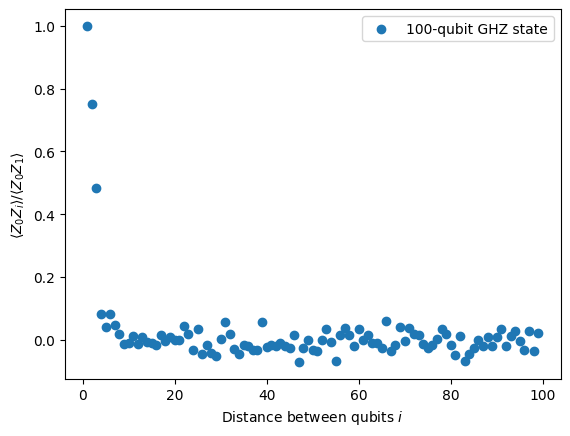

In [12]:
import matplotlib.pyplot as plt

data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.scatter(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle$')
plt.legend()
plt.show()

In [ ]:
# CHSH game implementation link on Qiskit 
# https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action
